In [1]:
import os, sys
os.environ['ON_PY']="1"
from params import parser
from common_utils import setup_seed
from data_utils import pack_data_from_config
import numpy as np
from test_script.base import Test
import matplotlib.pyplot as plt
import numpy as np

notebook_dir = os.getcwd()
print(notebook_dir)
# 将工作目录更改为上一级目录
os.chdir("/home/wlc/FJSP-DRL-MAML")



(CVXPY) Mar 07 10:08:18 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 07 10:08:18 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


/home/wlc/FJSP-DRL-MAML/plot_imgs


In [2]:
instances = ["10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix",]

plot_dict = {}
for key in instances:
    plot_dict[key] = [np.array(11) for _ in range(4)]

plot_dict

{'10x5+mix': [array(11), array(11), array(11), array(11)],
 '20x5+mix': [array(11), array(11), array(11), array(11)],
 '15x10+mix': [array(11), array(11), array(11), array(11)],
 '20x10+mix': [array(11), array(11), array(11), array(11)]}

In [ ]:
# 数学解



In [3]:
# DAN 解

args = ["--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix",
        "--test_model", "10x5x10+mix","20x5x10+mix", "15x10x10+mix", "20x10x10+mix"]
configs = parser.parse_args(args=args)

setup_seed(configs.seed_test)


test_model = []

for model_name in configs.test_model:
    test_model.append((f'./trained_network/{configs.model_source}/{model_name}.pth', model_name))
print(test_model)
test_data = pack_data_from_config(configs.data_source, configs.test_data)

print(os.getcwd())
baseline_makespans = []
for i in range(len(test_model)):
    model = test_model[i]
    data = test_data[i]
    print("datta[1]: ",data[1])
    print("-" * 25 + "Test Learned Model" + "-" * 25)
    print(f"test data name: {data[1]}")
    finetuning = True if model[1].startswith("maml") else False
    print(f"Model name : {model[1]}")
    result_5_times = []
    for j in range(2):
        test = Test(configs, data[0], model[0])
        result = test.greedy_strategy(finetuning=finetuning)
        # result = test_greedy_strategy(data[0], model[0], config.seed_test)
        
        result_5_times.append(result)
    result_5_times = np.array(result_5_times)

    save_result = np.mean(result_5_times, axis=0)
    print("testing results:")
    print(f"makespan(greedy): ", save_result[:, 0].mean())
    baseline_makespans.append(save_result[:, 0].mean())
    print(f"time: ", save_result[:, 1].mean())
    # print(f"Max fast_adapt cnt:", save_result[:, 2].max())
    # print(f"Average fast_adapt time:", save_result[:, 3].mean())
    print("="*100)

print(baseline_makespans)




[('./trained_network/SD2/10x5x10+mix.pth', '10x5x10+mix'), ('./trained_network/SD2/20x5x10+mix.pth', '20x5x10+mix'), ('./trained_network/SD2/15x10x10+mix.pth', '15x10x10+mix'), ('./trained_network/SD2/20x10x10+mix.pth', '20x10x10+mix')]
/home/wlc/FJSP-DRL-MAML
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : 10x5x10+mix
testing results:
makespan(greedy):  426.7
time:  0.3103303790092468
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : 20x5x10+mix
testing results:
makespan(greedy):  695.8
time:  0.598634660243988
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : 15x10x10+mix
testing results:
makespan(greedy):  570.9
time:  0.9066616058349609
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix


In [4]:
# MAML finetuning
# 获取finetuning的每个过程

def MAML_finetuning_test(args):
    configs = parser.parse_args(args=args)
    print(configs.hidden_dim_actor, configs.hidden_dim_critic)
    test_model = []

    for model_name in configs.test_model:
        test_model.append((f'./trained_network/{configs.model_source}/{model_name}.pth', model_name))
    print(test_model)

    model = test_model[0]

    test_data = pack_data_from_config(configs.data_source, configs.test_data)
    makespans = []
    finetuning_makespans = []
    for data in test_data:
        print("datta[1]: ",data[1])
        print("-" * 25 + "Test Learned Model" + "-" * 25)
        print(f"test data name: {data[1]}")
        if model[1].startswith("maml"): finetuning = True
        print(f"Model name : {model[1]}")
        result_5_times = []
        test = Test(configs, data[0], model[0])
        result = test.finetuning()
        finetuning_makespans.append(result)
        # result = test_greedy_strategy(data[0], model[0], config.seed_test)
        # print(result)
        for j in range(2):
            result = test.greedy_strategy()
            result_5_times.append(result)
        result_5_times = np.array(result_5_times)

        save_result = np.mean(result_5_times, axis=0)
        print("testing results:")
        print(f"makespan(greedy): ", save_result[:, 0].mean())
        makespans.append(save_result[:, 0].mean())
        print(f"time: ", save_result[:, 1].mean())
        # print(f"Max fast_adapt cnt:", save_result[:, 2].max())
        # print(f"Average fast_adapt time:", save_result[:, 3].mean())
        print("="*100)

    return makespans, finetuning_makespans



In [14]:
model = "maml+exp18-9"
# model = "maml+exp18-10"
# model = "maml+EXP19maml1707148858" #调整为竞争的工件和机器
# model = "maml+EXP19maml1707189752" #调整训练次数1->4
# model = "maml+EXP19maml1707277364" #只用MAML训练actor
# model = "maml+EXP19maml1708610726" # 内部更新feature_exact
# model = "maml+EXP19maml1709199921" # 缓更新
# model = "maml+EXP19maml1709210851" # adapt_lr=0.01
# model = "maml+EXP19maml1709211969" # adapt_lr=0.001
# model = "maml+EXP19maml1709212192" ## adapt_lr=0.0001
model = "maml+EXP19maml1709367712" # 无缓更新技术
model = "maml+EXP19maml1709693698"  ## feature_exact
model = "maml+EXP19maml1709779578"  # iter 500 + op_per_job=10
model = "maml+EXP19maml1709779197"  # iter = 500 op_per_job=M
model = "maml+EXP19maml1709816607"  ### 缓更新  iter=400
args = ["--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix", 
        "--hidden_dim_actor", "512", "--hidden_dim_critic", "512",
        "--test_model", model]

maml_makespans, maml_finetuning_makespans = MAML_finetuning_test(args)
print(maml_makespans)
print(maml_finetuning_makespans)


512 512
[('./trained_network/SD2/maml+EXP19maml1709816607.pth', 'maml+EXP19maml1709816607')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : maml+EXP19maml1709816607
testing results:
makespan(greedy):  454.5
time:  0.2947916269302368
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : maml+EXP19maml1709816607
testing results:
makespan(greedy):  734.9
time:  0.6030711650848388
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : maml+EXP19maml1709816607
testing results:
makespan(greedy):  639.4
time:  0.9146260380744934
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : maml+EXP19maml1709816607
testing results:
makespan(greedy):  708.5
time:  1.2374130964279175
[454.5, 734.9, 639.4, 7

In [6]:
# pretrain finetuning

args = ["--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix", 
        "--hidden_dim_actor", "512", "--hidden_dim_critic", "512",
        "--test_model", "maml+EXP19maml1709218650"]

pre_train_makespans, pre_train_finetuning_makespans = MAML_finetuning_test(args)


print(plot_dict)

512 512
[('./trained_network/SD2/maml+EXP19maml1709218650.pth', 'maml+EXP19maml1709218650')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : maml+EXP19maml1709218650
testing results:
makespan(greedy):  484.2
time:  0.29412522315979006
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : maml+EXP19maml1709218650
testing results:
makespan(greedy):  768.6
time:  0.5968143820762635
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : maml+EXP19maml1709218650
testing results:
makespan(greedy):  634.6
time:  0.9032202959060669
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : maml+EXP19maml1709218650
testing results:
makespan(greedy):  723.8
time:  1.2175113916397096
{'10x5+mix': [array(11

In [7]:
# random
import torch
from model.PPO import PPO_initialize

ppo = PPO_initialize(configs)

torch.save(ppo.policy.state_dict(), f'./trained_network/SD2/test_random.pth')

args = ["--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix", 
        "--test_model", "test_random"]

random_makespans, random_finetuning_makespans = MAML_finetuning_test(args)



64 64
[('./trained_network/SD2/test_random.pth', 'test_random')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : test_random
testing results:
makespan(greedy):  627.9
time:  0.2900505065917969
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : test_random
testing results:
makespan(greedy):  1174.8
time:  0.5905564188957214
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : test_random
testing results:
makespan(greedy):  943.8
time:  0.8969112396240234
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : test_random
testing results:
makespan(greedy):  1215.7
time:  1.2054250717163086


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for the 2D array (4 rows, 11 columns)

def plot_makespan(data, title):
    # Labels for the lines
    labels = ["DAN_baseline", "MAML", "pre_training", "random"]

    # Plotting the lines
    for i, row in enumerate(data):
        plt.plot(row, label=labels[i])
    plt.xlabel("Meta Iteration")
    plt.ylabel("Makespan")
    plt.title(title)
    plt.legend()
    plt.show()



{'10x5+mix': [array([426.7, 426.7, 426.7, 426.7, 426.7, 426.7, 426.7, 426.7, 426.7,
       426.7, 426.7]), array([487.5, 481.5, 465.1, 462.6, 476.5, 481.5, 461.1, 475.6, 473.1,
       456.6, 470.6]), array([503.9, 475.5, 504. , 477.3, 505.6, 476.3, 504.4, 497.7, 479.6,
       491.1, 483.6]), array([632.1, 612.4, 642.1, 619.6, 635.1, 626.8, 651. , 620. , 657.6,
       647.8, 658.1])], '20x5+mix': [array([695.8, 695.8, 695.8, 695.8, 695.8, 695.8, 695.8, 695.8, 695.8,
       695.8, 695.8]), array([755.5, 759.4, 758.3, 740.1, 750.8, 761.7, 753.9, 745.3, 754.9,
       747.1, 745.2]), array([791.6, 784. , 777.9, 759.9, 793.1, 772.3, 767.2, 788.5, 788.5,
       806.5, 769.3]), array([1154.4, 1152. , 1175.9, 1129.6, 1158.1, 1154.2, 1143.9, 1119.6,
       1135.5, 1118.7, 1146.5])], '15x10+mix': [array([570.9, 570.9, 570.9, 570.9, 570.9, 570.9, 570.9, 570.9, 570.9,
       570.9, 570.9]), array([641.5, 624.5, 654.3, 644.3, 619.2, 635.5, 617.9, 644.7, 643.5,
       643.4, 645.6]), array([629.9, 63

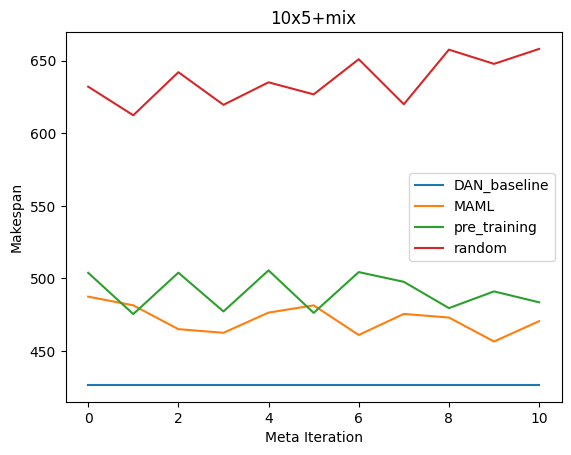

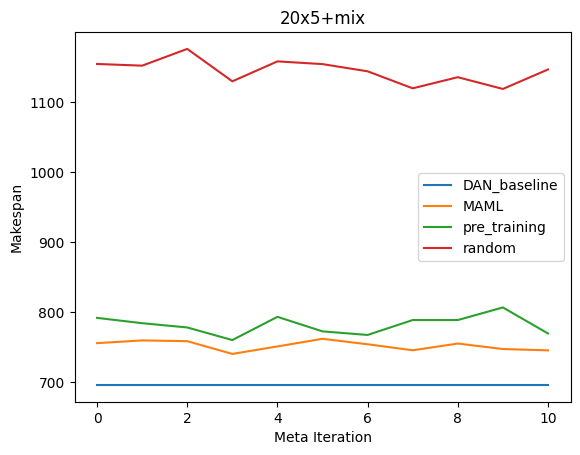

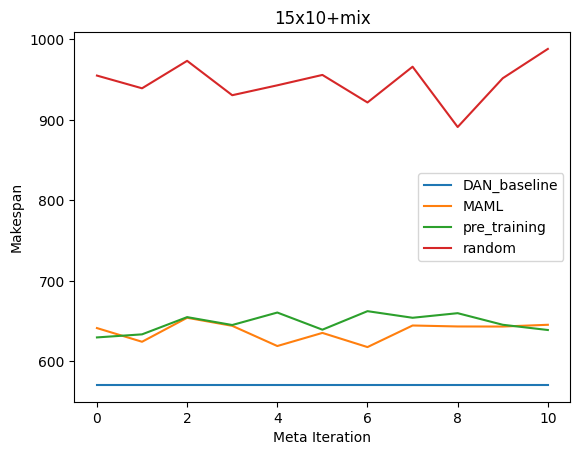

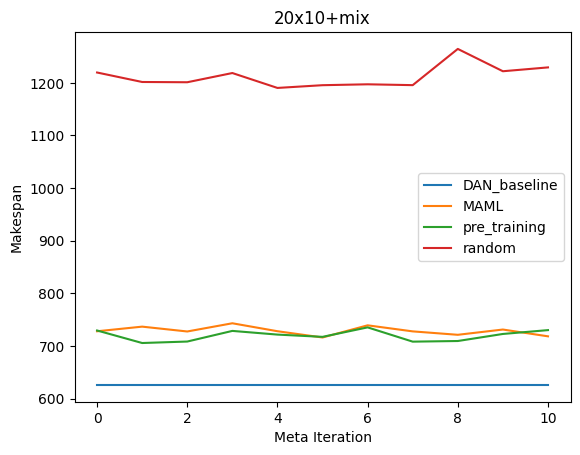

In [15]:

for idx, key in enumerate(instances):
    # plot_dict[key][0] = [baseline_makespans[idx]  for _ in range(configs.adapt_nums)]
    plot_dict[key][0] = np.full(configs.adapt_nums, baseline_makespans[idx])
    plot_dict[key][1] = maml_finetuning_makespans[idx]
    plot_dict[key][2] = pre_train_finetuning_makespans[idx]
    plot_dict[key][3] = random_finetuning_makespans[idx]

print(plot_dict)

for key in instances:
    data = plot_dict[key]
    plot_makespan(data, key)